In [11]:
import numpy as np
import pandas as pd
from pathlib import Path
import os
import 

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

import tensorflow as tf

from sklearn.metrics import confusion_matrix, classification_report

In [35]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


In [12]:
image_dir = Path('D:\BANGKIT\Capstone\Soto-Machine-Learning\Data')

In [13]:
filepaths = list(image_dir.glob(r'**/*.jpg'))
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

images = pd.concat([filepaths, labels], axis=1)

category_samples = []
for category in images['Label'].unique():
    category_slice = images.query("Label == @category")
    category_samples.append(category_slice.sample(200, random_state=1))
image_df = pd.concat(category_samples, axis=0).sample(frac=1.0, random_state=1).reset_index(drop=True)

In [14]:
image_df

,Filepath,Label
0,D:\BANGKIT\Capstone\Soto-Machine-Learning\Data...,telur_balado
1,D:\BANGKIT\Capstone\Soto-Machine-Learning\Data...,daging_rendang
2,D:\BANGKIT\Capstone\Soto-Machine-Learning\Data...,dendeng_batokok
3,D:\BANGKIT\Capstone\Soto-Machine-Learning\Data...,gulai_tunjang
4,D:\BANGKIT\Capstone\Soto-Machine-Learning\Data...,gulai_ikan
...,...,...
1795,D:\BANGKIT\Capstone\Soto-Machine-Learning\Data...,gulai_ikan
1796,D:\BANGKIT\Capstone\Soto-Machine-Learning\Data...,telur_dadar
1797,D:\BANGKIT\Capstone\Soto-Machine-Learning\Data...,gulai_tambusu
1798,D:\BANGKIT\Capstone\Soto-Machine-Learning\Data...,ayam_pop


In [15]:
image_df['Label'].value_counts()

telur_balado       200
daging_rendang     200
dendeng_batokok    200
gulai_tunjang      200
gulai_ikan         200
ayam_goreng        200
telur_dadar        200
gulai_tambusu      200
ayam_pop           200
Name: Label, dtype: int64

In [16]:
train_df, test_df = train_test_split(image_df, train_size=0.7, shuffle=True, random_state=1)

In [26]:
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
    validation_split=0.2,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

In [27]:
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='training'
)

val_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

Found 1008 validated image filenames belonging to 9 classes.
Found 252 validated image filenames belonging to 9 classes.
Found 540 validated image filenames belonging to 9 classes.


In [28]:
pretrained_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

pretrained_model.trainable = False

In [29]:
inputs = pretrained_model.input

x = tf.keras.layers.Dense(128, activation='relu')(pretrained_model.output)
x = tf.keras.layers.Dense(128, activation='relu')(x)

outputs = tf.keras.layers.Dense(9, activation='softmax')(x)

model = tf.keras.Model(inputs, outputs)


print(model.summary())

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                                           

In [30]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_images,
    validation_data=val_images,
    epochs=100,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=3,
            restore_best_weights=True
        )
    ]
)

Epoch 1/100
32/32 [==============================] - 81s 2s/step - loss: 1.4739 - accuracy: 0.5218 - val_loss: 0.6770 - val_accuracy: 0.7857
Epoch 2/100
32/32 [==============================] - 70s 2s/step - loss: 0.5912 - accuracy: 0.7907 - val_loss: 0.5150 - val_accuracy: 0.8214
Epoch 3/100
32/32 [==============================] - 72s 2s/step - loss: 0.4346 - accuracy: 0.8532 - val_loss: 0.4187 - val_accuracy: 0.8492
Epoch 4/100
32/32 [==============================] - 72s 2s/step - loss: 0.3137 - accuracy: 0.9048 - val_loss: 0.5179 - val_accuracy: 0.8254
Epoch 5/100
32/32 [==============================] - 75s 2s/step - loss: 0.3229 - accuracy: 0.8869 - val_loss: 0.3320 - val_accuracy: 0.8929
Epoch 6/100
32/32 [==============================] - 75s 2s/step - loss: 0.2434 - accuracy: 0.9196 - val_loss: 0.5250 - val_accuracy: 0.8175
Epoch 7/100
32/32 [==============================] - 68s 2s/step - loss: 0.2270 - accuracy: 0.9325 - val_loss: 0.4490 - val_accuracy: 0.8651
Epoch 8/100
3

In [31]:
results = model.evaluate(test_images, verbose=2)
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

17/17 - 21s - loss: 0.3739 - accuracy: 0.8741 - 21s/epoch - 1s/step
Test Accuracy: 87.41%


In [32]:
predictions = np.argmax(model.predict(test_images), axis=1)

cm = confusion_matrix(test_images.labels, predictions)
clr = classification_report(test_images.labels, predictions, target_names=test_images.class_indices, zero_division=0)

17/17 [==============================] - 22s 1s/step


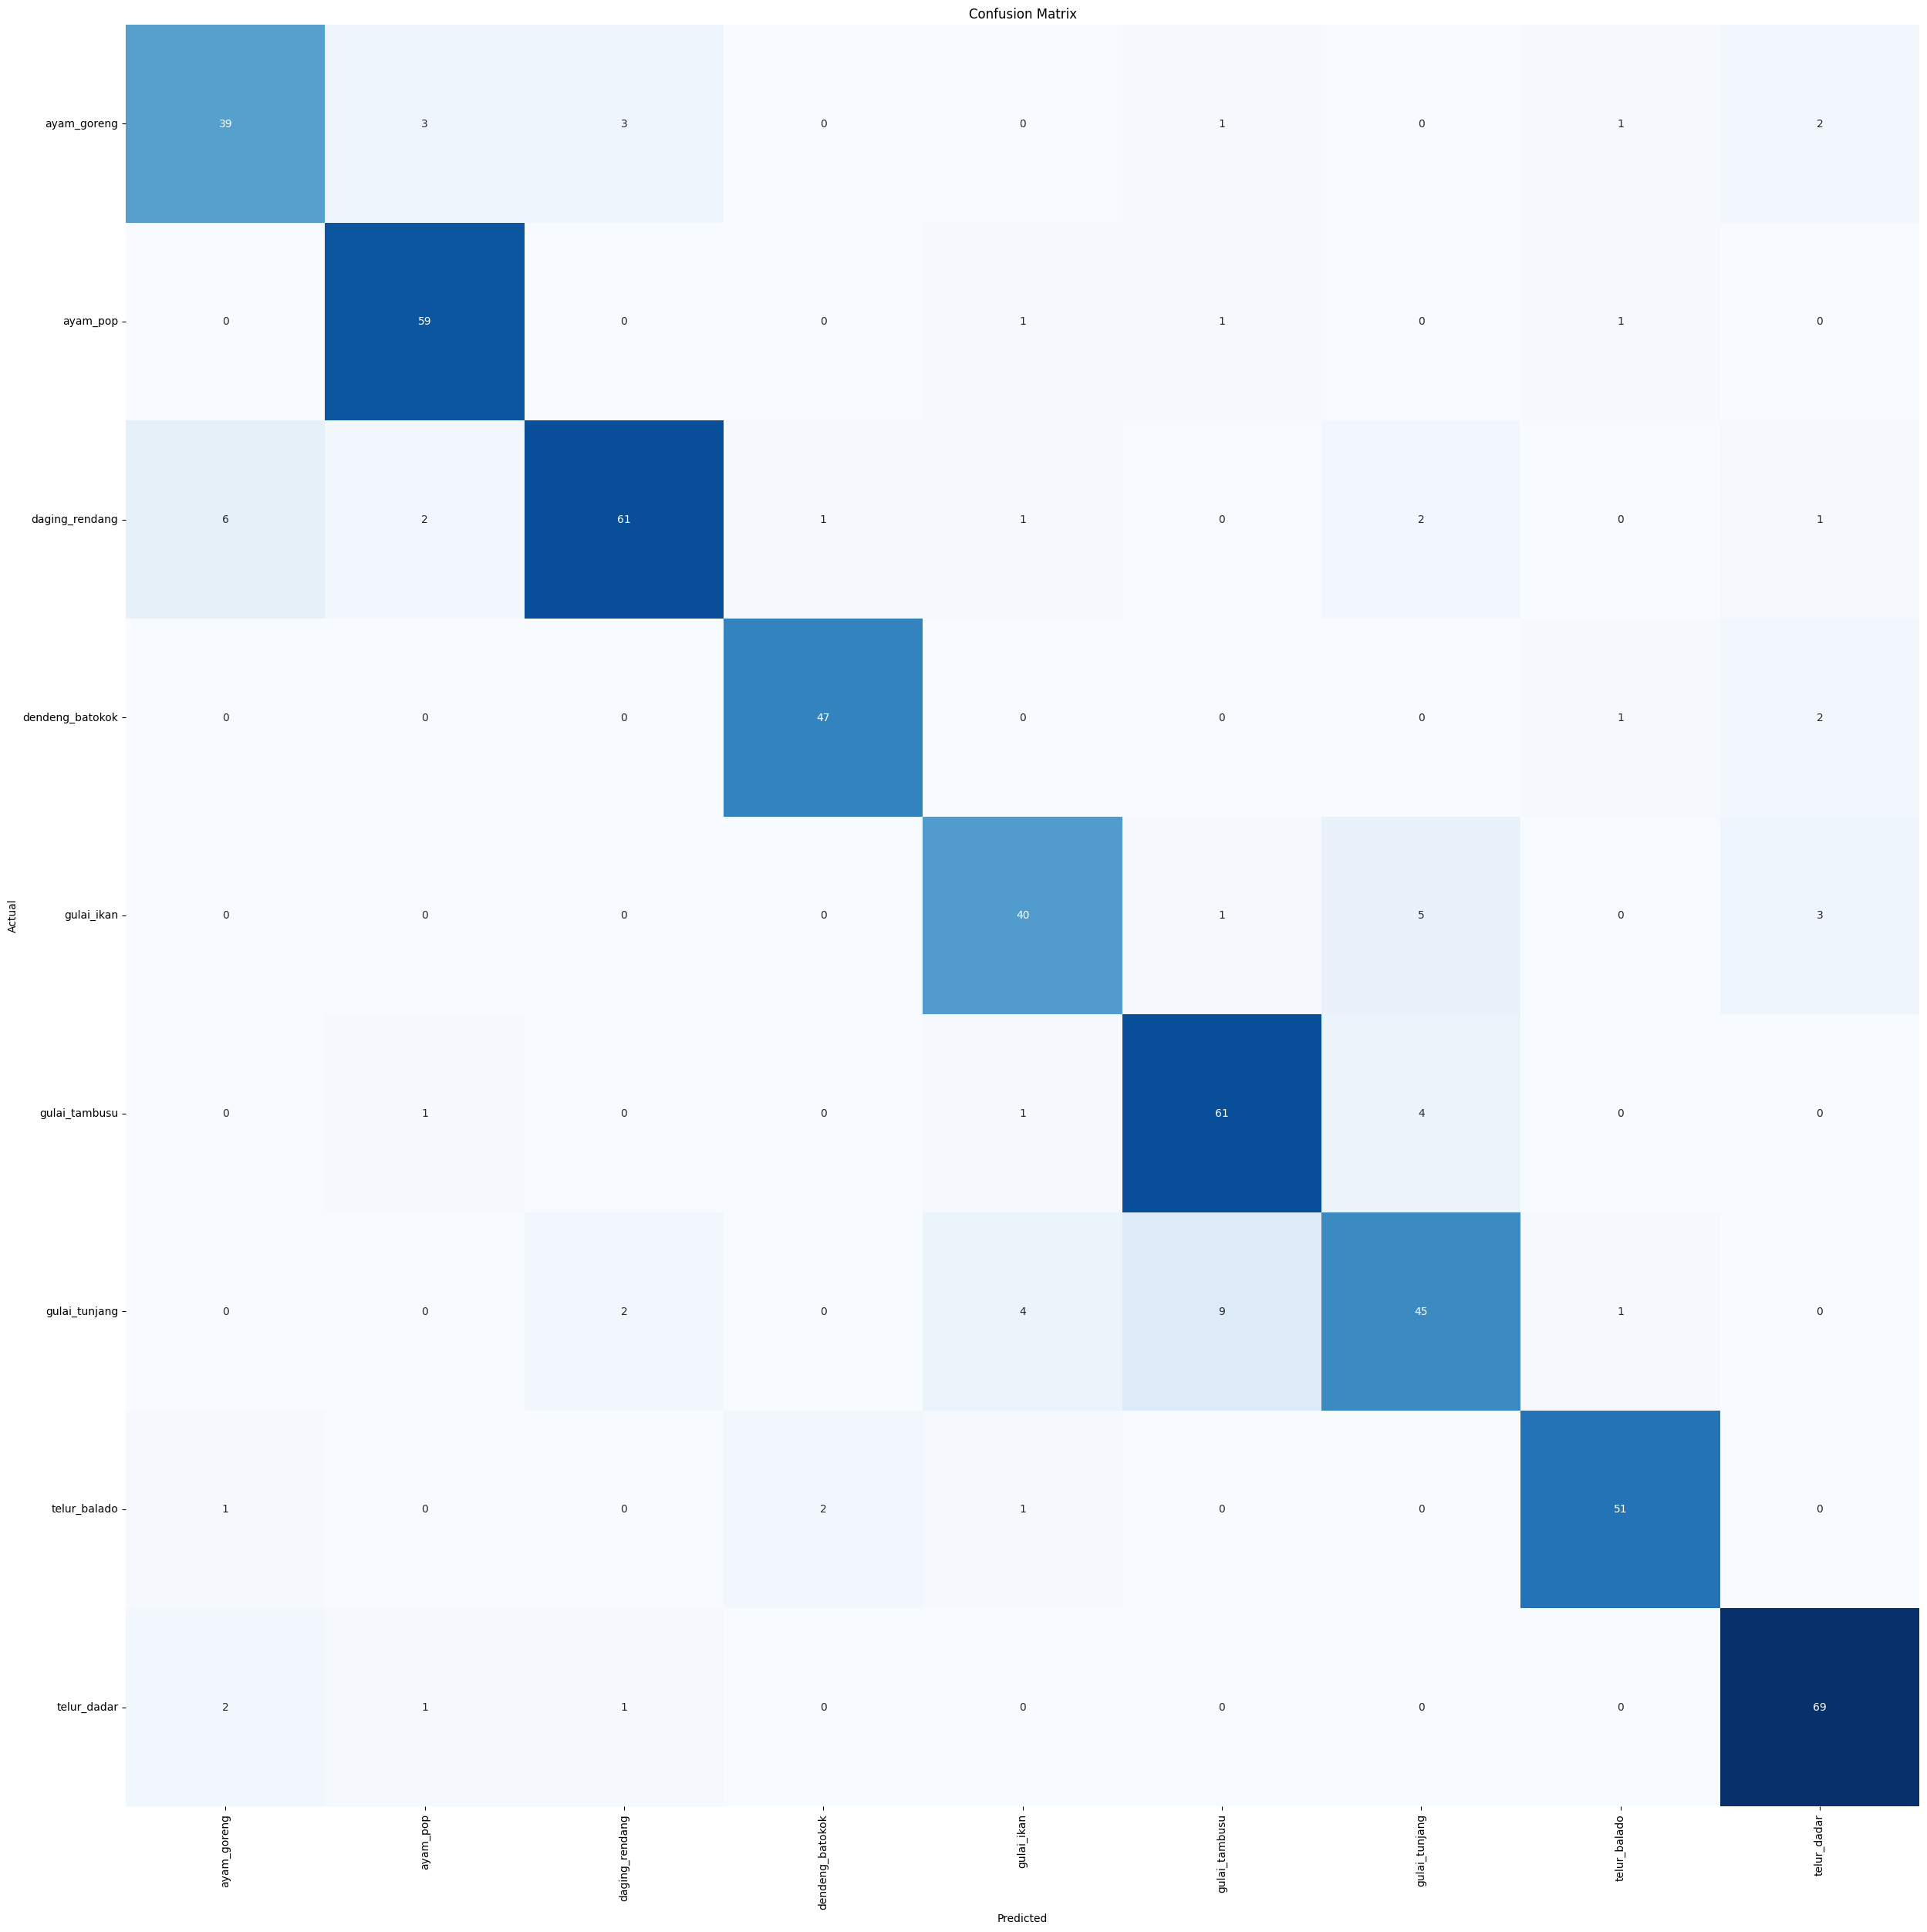

In [33]:
plt.figure(figsize=(30, 30))
sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='Blues', cbar=False)
plt.xticks(ticks=np.arange(9) + 0.5, labels=test_images.class_indices, rotation=90)
plt.yticks(ticks=np.arange(9) + 0.5, labels=test_images.class_indices, rotation=0)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

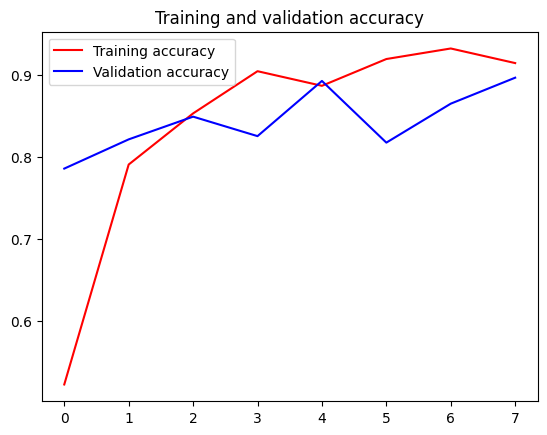

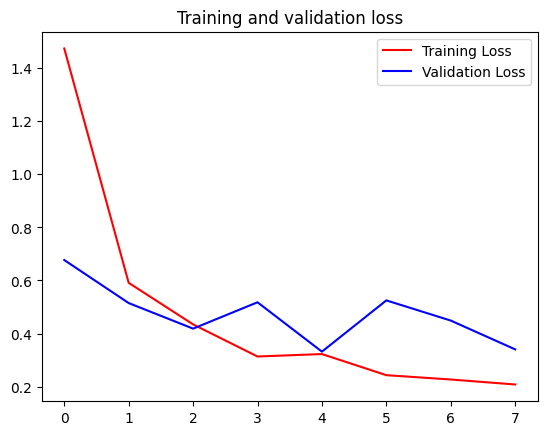

In [34]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

In [25]:
print("Classification Report:\n----------------------\n", clr)

Classification Report:
----------------------
                  precision    recall  f1-score   support

    ayam_goreng       0.88      0.76      0.81        49
       ayam_pop       0.94      0.97      0.95        62
 daging_rendang       0.87      0.89      0.88        74
dendeng_batokok       0.88      0.92      0.90        50
     gulai_ikan       0.74      0.86      0.79        49
  gulai_tambusu       0.85      0.85      0.85        67
  gulai_tunjang       0.80      0.66      0.72        61
   telur_balado       0.89      0.87      0.88        55
    telur_dadar       0.88      0.95      0.91        73

       accuracy                           0.86       540
      macro avg       0.86      0.86      0.86       540
   weighted avg       0.86      0.86      0.86       540

